# Определение возраста покупателей

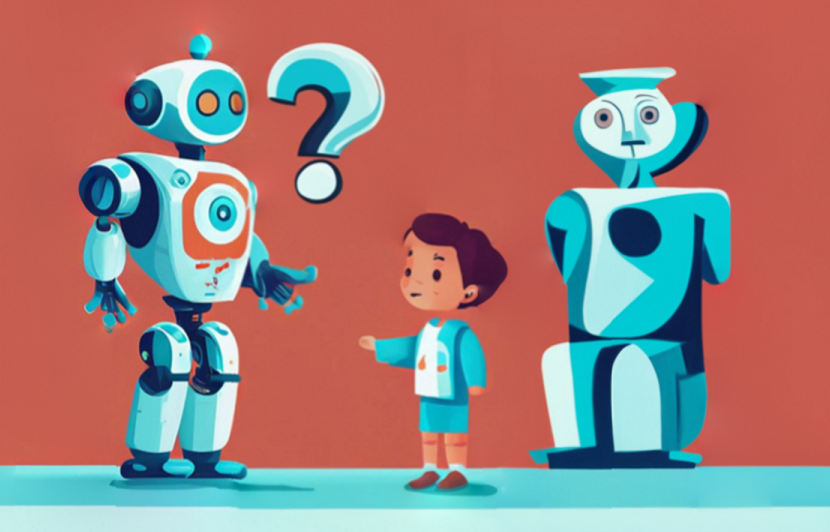

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

<b>Запрос заказчика:</b> 
   - Построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Необхоодимо:
- Провести исследовательский анализ набора фотографий;
- Подготовить данные к обучению;
- Обучить нейронную сеть и рассчитать её качество.

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
display(labels.describe()), display(labels.head()), labels.info()
None

real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


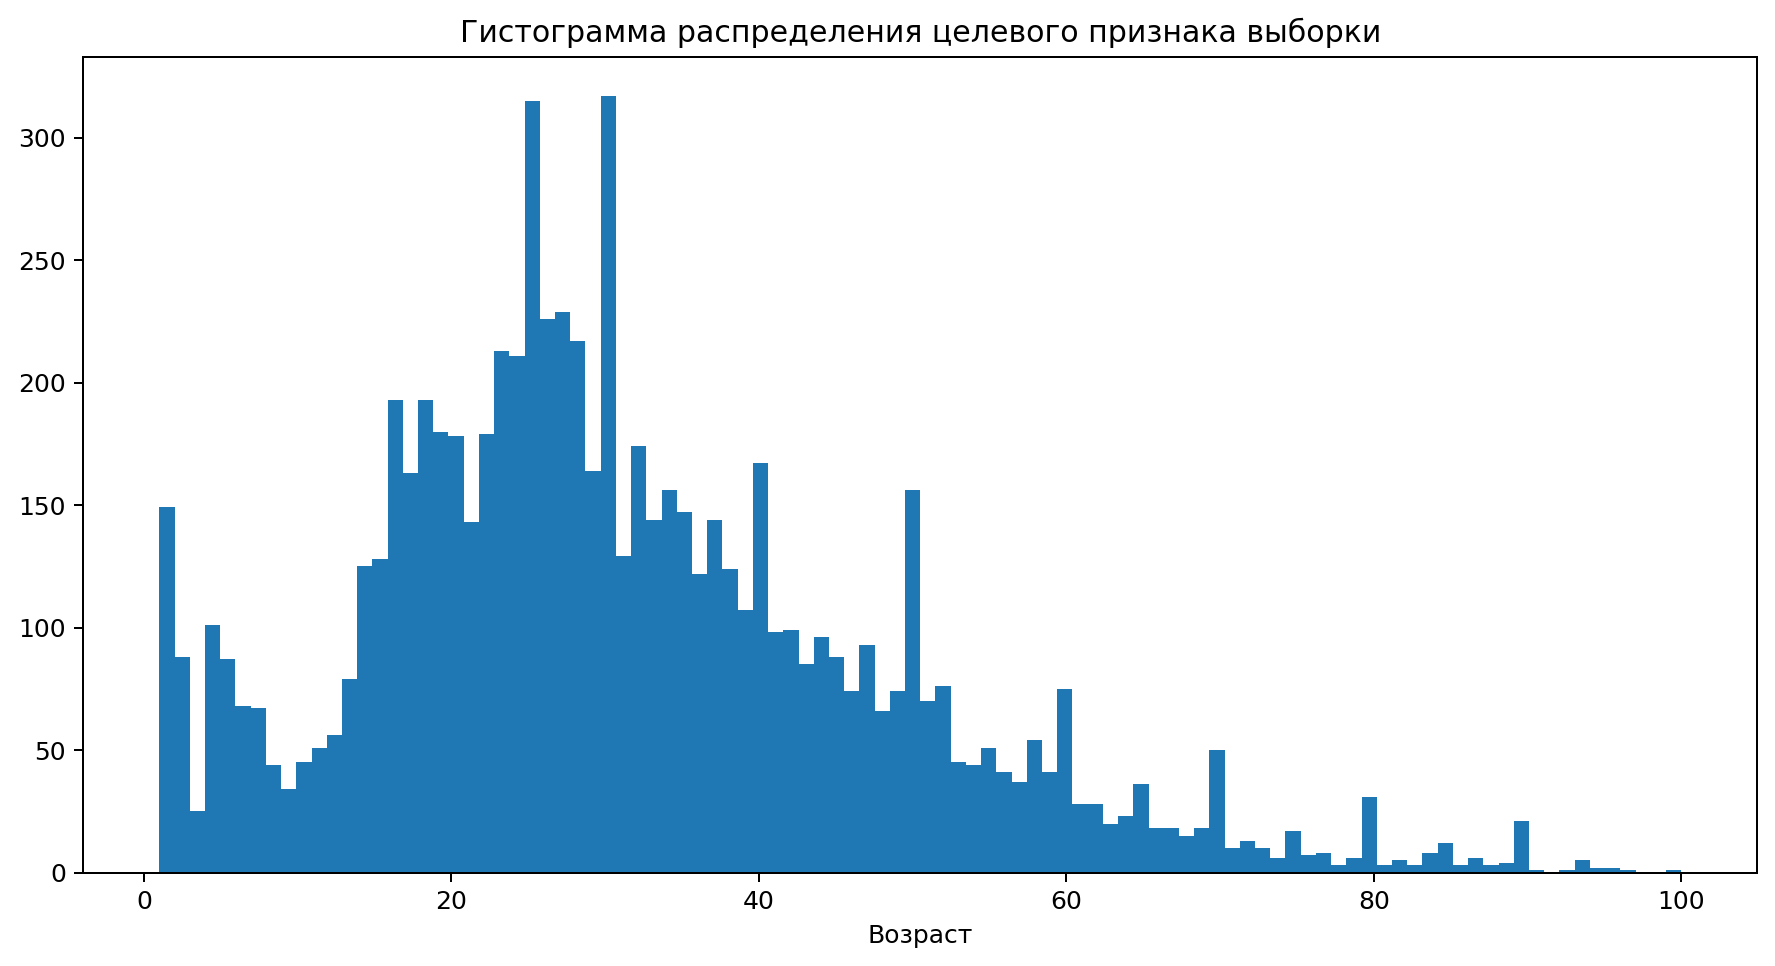

In [4]:
#labels['real_age'].hist(bins = 100)
plt.figure(figsize=(12,6), dpi=180)
plt.hist(labels['real_age'], bins = 100)
plt.title('Гистограмма распределения целевого признака выборки')
plt.xlabel('Возраст')
None


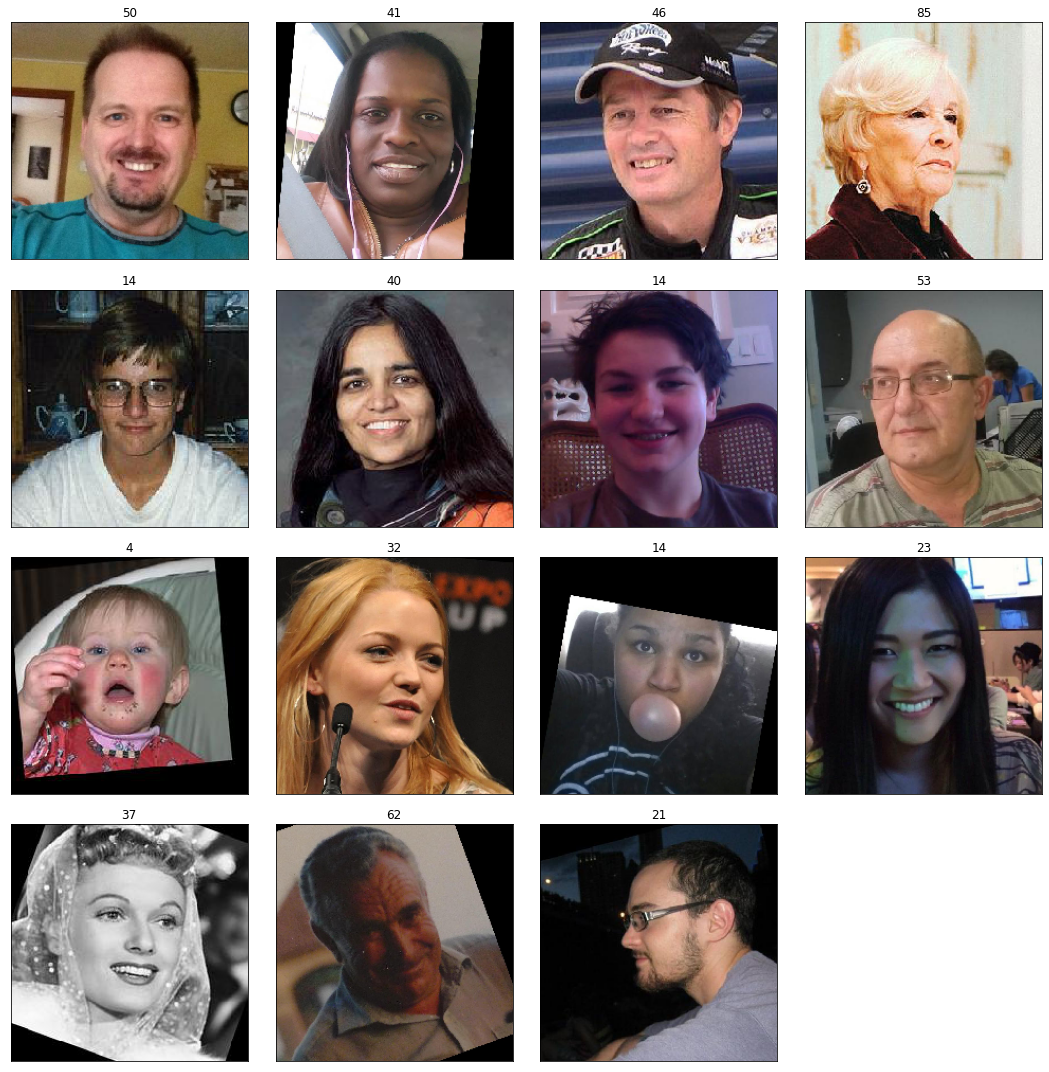

In [5]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

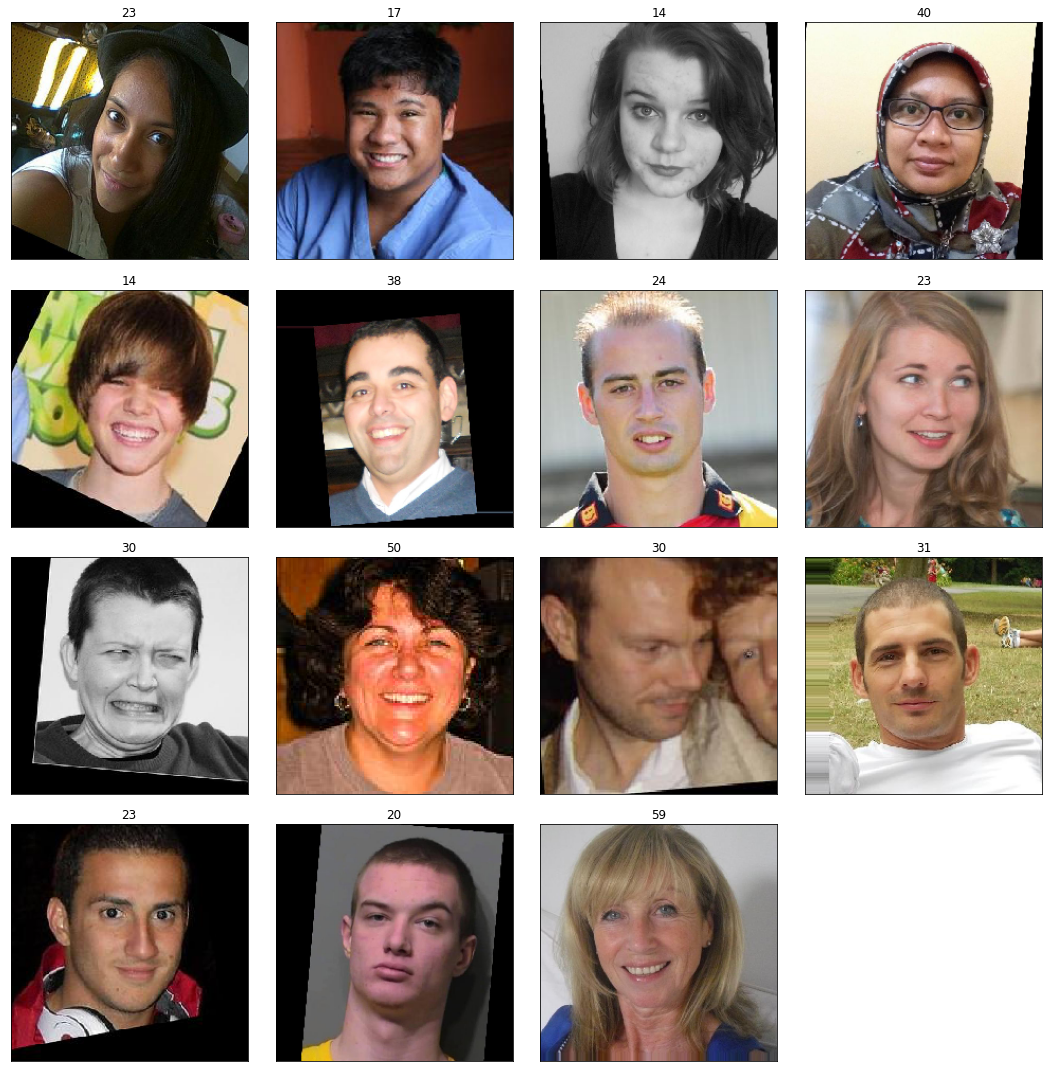

In [6]:
features, target = next(train_gen_flow)
features, target = next(train_gen_flow)
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

- У нас есть 7591 изображение с указанием возраста. Набор без пропусков;
    
- Люди, видимо, любят фотографироваться и попадать в дата-сеты в круглые даты, поэтому пики, как всегда, на количествах фотографий 25-30-40-50 лет;
    
- 50% данных лежат в между 20 и 41 годами. Лишь 25% данных содержит возраста выше 41 года, что явно не соответствует пропорциям покаупателей в магазине. Ещё 10% данных - фото детей до 12 лет. Так же слабо релевантные данные. Вряд ли их заинтересуют акции и кто-то в здравом уме продаст им алкоголь. Вероятно, лучшая точность будет лишь в диапазоне 20-40 лет; 

- В датасете есть старые и черно-белые фотографии. Возможно, стоит подкрутить цветовые каналы или яркость;

- В датасете есть фотогарафи, на которых лица изображены под разными углами к вертикальной оси. Имеет смысл делать аугментацию с rotation_range равным +-15-20 градусов в некотором проценте случаев. Поворачивать можно как само изображение так и объект отдельно от фона;

- В датасете есть фотогарафи, на которых лица изображены в полупрофиль. Имеет смысл делать аугментацию с отражением по горизонтали в некотором проценте случаев;

- В датасете есть фотогарафи с разным разрешением. Имеет смысл делать аугментацию с изменением контрастности изображения в некотором проценте случаев;

- В датасете есть фотогарафи, на которых изображены не лица, а голова и часть туловища (иногда человек послностью). Имеет смысл делать аугментацию с обезкой и масштабированием изображения в некотором проценте случаев, чтобы на фото были только лица примерно одного масштаба.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

- Используем ResNet, сделаем 10 эпох. 
- Добавляем аугментацию.

```python

from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        rescale= 1/ 255.)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + '/final_files/',
        target_size=(224, 224),
        x_col='file_name',
        y_col='real_age',
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        #horizontal_flip=True,
        #vertical_flip=True,
        rescale= 1/ 255.)

    test_datagen_flow  = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + '/final_files/',
        target_size=(224, 224),
        x_col='file_name',
        y_col='real_age',
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow



def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
2022-10-04 12:29:01.299563: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-04 12:29:01.695352: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 57s - loss: 240.6548 - mae: 11.3606 - val_loss: 652.0922 - val_mae: 20.5577
Epoch 2/10
356/356 - 47s - loss: 115.1485 - mae: 8.1824 - val_loss: 139.6838 - val_mae: 9.2839
Epoch 3/10
356/356 - 46s - loss: 91.9419 - mae: 7.2339 - val_loss: 115.4890 - val_mae: 8.1068
Epoch 4/10
356/356 - 46s - loss: 74.2980 - mae: 6.5652 - val_loss: 90.0931 - val_mae: 7.0188
Epoch 5/10
356/356 - 46s - loss: 62.0057 - mae: 6.0249 - val_loss: 85.8903 - val_mae: 6.9624
Epoch 6/10
356/356 - 46s - loss: 52.6554 - mae: 5.5390 - val_loss: 85.6081 - val_mae: 6.9490
Epoch 7/10
356/356 - 47s - loss: 47.6749 - mae: 5.3179 - val_loss: 115.2310 - val_mae: 8.2484
Epoch 8/10
356/356 - 47s - loss: 40.5910 - mae: 4.8687 - val_loss: 84.8897 - val_mae: 6.9303
Epoch 9/10
356/356 - 46s - loss: 35.3479 - mae: 4.5758 - val_loss: 92.8243 - val_mae: 7.4915
Epoch 10/10
356/356 - 47s - loss: 31.3993 - mae: 4.2623 - val_loss: 87.3754 - val_mae: 6.9106
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 87.3754 - mae: 6.9106
Test MAE: 6.9106

```

- Используем ResNet с 30 эпохами.

```python

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

Train for 356 steps, validate for 119 steps
Epoch 1/30
2022-10-04 13:59:34.710226: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-04 13:59:35.245491: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 77s - loss: 240.6998 - mae: 11.4131 - val_loss: 445.2370 - val_mae: 16.0400
Epoch 2/30
356/356 - 54s - loss: 113.9137 - mae: 8.1222 - val_loss: 153.5969 - val_mae: 9.4971
Epoch 3/30
356/356 - 44s - loss: 89.1509 - mae: 7.1821 - val_loss: 103.3308 - val_mae: 7.6649
Epoch 4/30
356/356 - 59s - loss: 73.9722 - mae: 6.5357 - val_loss: 98.9573 - val_mae: 7.5568

Epoch 7/30
356/356 - 81s - loss: 49.0841 - mae: 5.2836 - val_loss: 92.2377 - val_mae: 7.2817

Epoch 11/30
356/356 - 82s - loss: 29.4597 - mae: 4.1285 - val_loss: 76.6149 - val_mae: 6.5606

Epoch 15/30
356/356 - 60s - loss: 20.7246 - mae: 3.4776 - val_loss: 77.5947 - val_mae: 6.6347

Epoch 20/30
356/356 - 82s - loss: 15.7166 - mae: 3.0256 - val_loss: 79.2595 - val_mae: 6.5272

Epoch 24/30
356/356 - 53s - loss: 14.2324 - mae: 2.9047 - val_loss: 76.4419 - val_mae: 6.6360
Epoch 25/30
356/356 - 53s - loss: 12.6803 - mae: 2.7132 - val_loss: 68.6502 - val_mae: 6.1991
Epoch 26/30
356/356 - 50s - loss: 12.2198 - mae: 2.6505 - val_loss: 67.4909 - val_mae: 6.1985
Epoch 27/30
356/356 - 48s - loss: 12.4587 - mae: 2.6810 - val_loss: 65.5304 - val_mae: 5.9787
Epoch 28/30
356/356 - 49s - loss: 11.7149 - mae: 2.5971 - val_loss: 65.1518 - val_mae: 6.0919
Epoch 29/30
356/356 - 48s - loss: 11.5396 - mae: 2.6159 - val_loss: 72.5066 - val_mae: 6.3478
Epoch 30/30
356/356 - 49s - loss: 11.6671 - mae: 2.5931 - val_loss: 68.9559 - val_mae: 6.2285
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 68.9559 - mae: 6.2285
Test MAE: 6.2285
```

## Анализ обученной модели

- Проанализировали разные варианты моделей со сверх-новыми модными алгоритмами ResNet, где затуханию градиента потерь препятствуют shortcut connection.
- Поскольку GPU был занят другими сотрудниками, а метод его использования значительно ограничен, были испытаны только предзагруженные модели с 10 и 30 эпохами.
- Для обучения моделей использовалась аугментация входных изображений.
- Можно сказать, что черезмерное усложнение модели лишь ухудшает её свойства, а алгоритм Adam в сочетании с резнетом позволяет достичь требуемой точности за небольшой промежуток веремени.
 
    Лучшие полученные значения - 2.59 на обучающей выборке и 6.23 на валидационной.    
    